# Excess Gibbs and enthalpy with F-SAC+f(T)

In this notebook, we use our SAC equations as the basis for F-SAC calculations for the case of
**temperature dependent** interaction energies.

For a simpler example, please check the [fsac_energies notebook](./fsac_energies.ipynb).

The F-SAC model uses the exact same SAC equations but with the compound segments defined by a group
contribution method and interaction among groups as in the COSMO-SAC/RS models.

The basic literature is:
 - [Functional-Segment Activity Coefficient model. 1. Model formulation](http://dx.doi.org/10.1021/ie400170a). Industrial & Engineering Chemistry Research, v. 52, p. 11159-11171, 2013.
 - [Functional-Segment Activity Coefficient model. 2. Associating mixtures](http://dx.doi.org/10.1021/ie4013979). Industrial & Engineering Chemistry Research, v. 52, p. 11172-11181, 2013.

We start by importing the necessary packages.

In [6]:
import math
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC
from pysac import RGAS

### Compound definitions

In F-SAC, compounds are defined with just a few surface areas and their respective charge densities.

Linear hydrocarbons are all neutral and polar compounds have a neutral, positive, and negative portions.

For **acetone**, our first compound, we have three segment types, neutral, positive, and negative. While **n-hexane** can be represented by a single segment type, all neutral.

In [7]:
sigma_1 = [0.0]
Q_1     = [191.93]

sigma_2 = [0,      0.0132, -0.00363]
Q_2     = [20.167, 21.97,  80.23]

## F-SAC implementation

Now we derive our general SAC equations to work as a F-SAC implementation by deriving the basic `SAC` class and implementing the method calculating the interaction energies, `calc_u`.

In this example, we use **temperature dependent** interaction energies by the following multiplying factor:
\begin{equation}
f(T) = \exp \left (-\beta \frac{T-T_0}{1000 \cdot \text{K}} \right )
\end{equation}

This function returns 1 when $T=T_0$, being an exponential decay with the temperature.

In [8]:
# F-SAC parameters
alpha = 8544.6
Q_eff = 3.597

# The mixture area and sigma arrays
Q = [Q_1, Q_2]
sigma = [sigma_1, sigma_2]

T0 = 308.15
beta = 1

class FSACNonHB(SAC):
    def __init__(self):
        super().__init__(Q_eff=Q_eff)

    def calc_u(self, T, i, j, m, n):
        '''
        Interaction energies, only the electrostatic contribution (no hydrogen bonding)
        and temperature dependent.
        '''
        f = math.exp(-beta * (T - T0)/1000)
        return f*(alpha/2)*(sigma[i][m]+sigma[j][n])**2
    
    def calc_du_dT(self, T, i, j, m, n):
        '''
        Returns the derivative of the interaction energy.
        '''
        f = math.exp(-beta * (T - T0)/1000)
        u = self.calc_u(T, i, j, m, n)
        
        return -beta/1000 * u * f


# Create an instance of our F-SAC class
sac = FSACNonHB()

# Set a temperature and the areas of our compounds
T = T0
sac.set_compounds(Q)
sac.set_temperature(T)

### Excess properties

Here we compare the F-SAC Gibbs excess energy and enthalpy with experimental data at 308.15 K.
We are disregarding any combinatorial comtribution in this example, since the molecules have similar size and shape.

Gibbs excess experimental data comes from *Zh. Prikl. Khim, 36, p 1471, 1963* vapor-liquid equilibria data, assuming the Raoult's law is valid.
For the excess enthalpy, experimental data comes form
<a href="https://doi.org/10.1016/0040-6031(90)80350-8">Singh et al., 1990</a>.

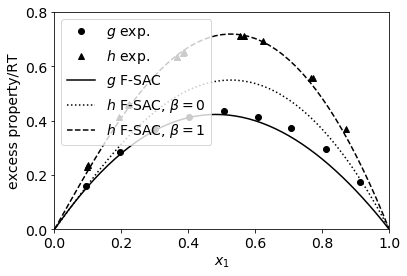

In [9]:
x1_ge_exp = [0.094, 0.1951, 0.3005, 0.4004, 0.5055, 0.6083, 0.7055, 0.8098, 0.9138]
ge_exp = [0.1597, 0.2847, 0.3691, 0.4151, 0.4371, 0.4144, 0.3740, 0.2971, 0.1747]

x1_he_exp = [0.0958, 0.0995, 0.1931, 0.2191, 0.2229, 0.3651, 0.3655, 0.3831, 0.388, 0.5551, 0.5651, 0.6219, 0.7677, 0.7713, 0.8714]
he_exp = [0.2302, 0.2353, 0.4137, 0.4570, 0.4625, 0.6330, 0.6358, 0.6475, 0.6510, 0.7123, 0.7119, 0.6947, 0.5581, 0.5554, 0.3680]

N = 51
ue = []
ae = []

x1 = []

beta = 1
for l in range(N):
    x1_ = l/(N-1)
    x1.append(x1_)

    x = [x1_, 1-x1_]
    
    sac.set_composition(x)
    sac.calc_ln_gamma()

    ae_ = sac.get_helmholtz()
    ue_ = sac.get_energy()

    # subtract the pure compound energies
    for i in range(len(x)):
        ue_ -= x[i]*sac.get_energy_pure(i)
        ae_ -= x[i]*sac.get_helmholtz_pure(i)
    
    ae.append(ae_)
    ue.append(ue_)

beta = 0
ue0 = []
for l in range(N):
    x1_ = l/(N-1)
    x = [x1_, 1-x1_]
    
    sac.set_composition(x)
    sac.calc_ln_gamma()

    ue_ = sac.get_energy()

    # subtract the pure compound energies
    for i in range(len(x)):
        ue_ -= x[i]*sac.get_energy_pure(i)
    
    ue0.append(ue_)

plt.plot(x1_ge_exp, ge_exp, 'ko', label=r'$g$ exp.')
plt.plot(x1_he_exp, he_exp, 'k^', label=r'$h$ exp.')
plt.plot(x1, ae, 'k-', label=r'$g$ F-SAC')
plt.plot(x1, ue0, 'k:', label=r'$h$ F-SAC, $\beta=0$')
plt.plot(x1, ue, 'k--', label=r'$h$ F-SAC, $\beta=1$')

plt.legend(loc='upper left')
plt.xlabel(r'$x_1$')
plt.ylabel(r'excess property/RT')
plt.xlim([0, 1])
plt.ylim([0, 0.8])

plt.rcParams.update({'font.size': 14})
plt.plot()
plt.savefig('pdf/f-sac-excess.pdf')

From the results above, we can see F-SAC can represent very well the Gibbs excess energy for this case.
If interaction energies are temperature independent ($\beta=0$), then the excess enthalpy is underpredicted.
When temperature dependent interaction energies are used ($\beta=1$), there is very good agreement between
calculated excess enthalpies and experimental data.

For this case, Gibbs excess would be the same for any $\beta$, since our reference temperature $T_0$ is exactly the temperature of the experimental, making the multiplying factor $f(T=T_0) = 1$ but $
\partial f/ \partial T \neq 0$.